In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import numpy as np

##a) Exploración de Datos

In [2]:
# Leer el archivo CSV
!curl -O "https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/refs/heads/main/data/MulticlassDiabetesDataset.csv"

df = pd.read_csv("MulticlassDiabetesDataset.csv")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11022  100 11022    0     0  43277      0 --:--:-- --:--:-- --:--:-- 43393


In [3]:
clases = df["Class"].value_counts()

print(clases)

Class
2    128
0     96
1     40
Name: count, dtype: int64


Son 264 sujetos, de los cuales 96 no muestran síntomas, 40 presentan prediabetes y 128 diabetes

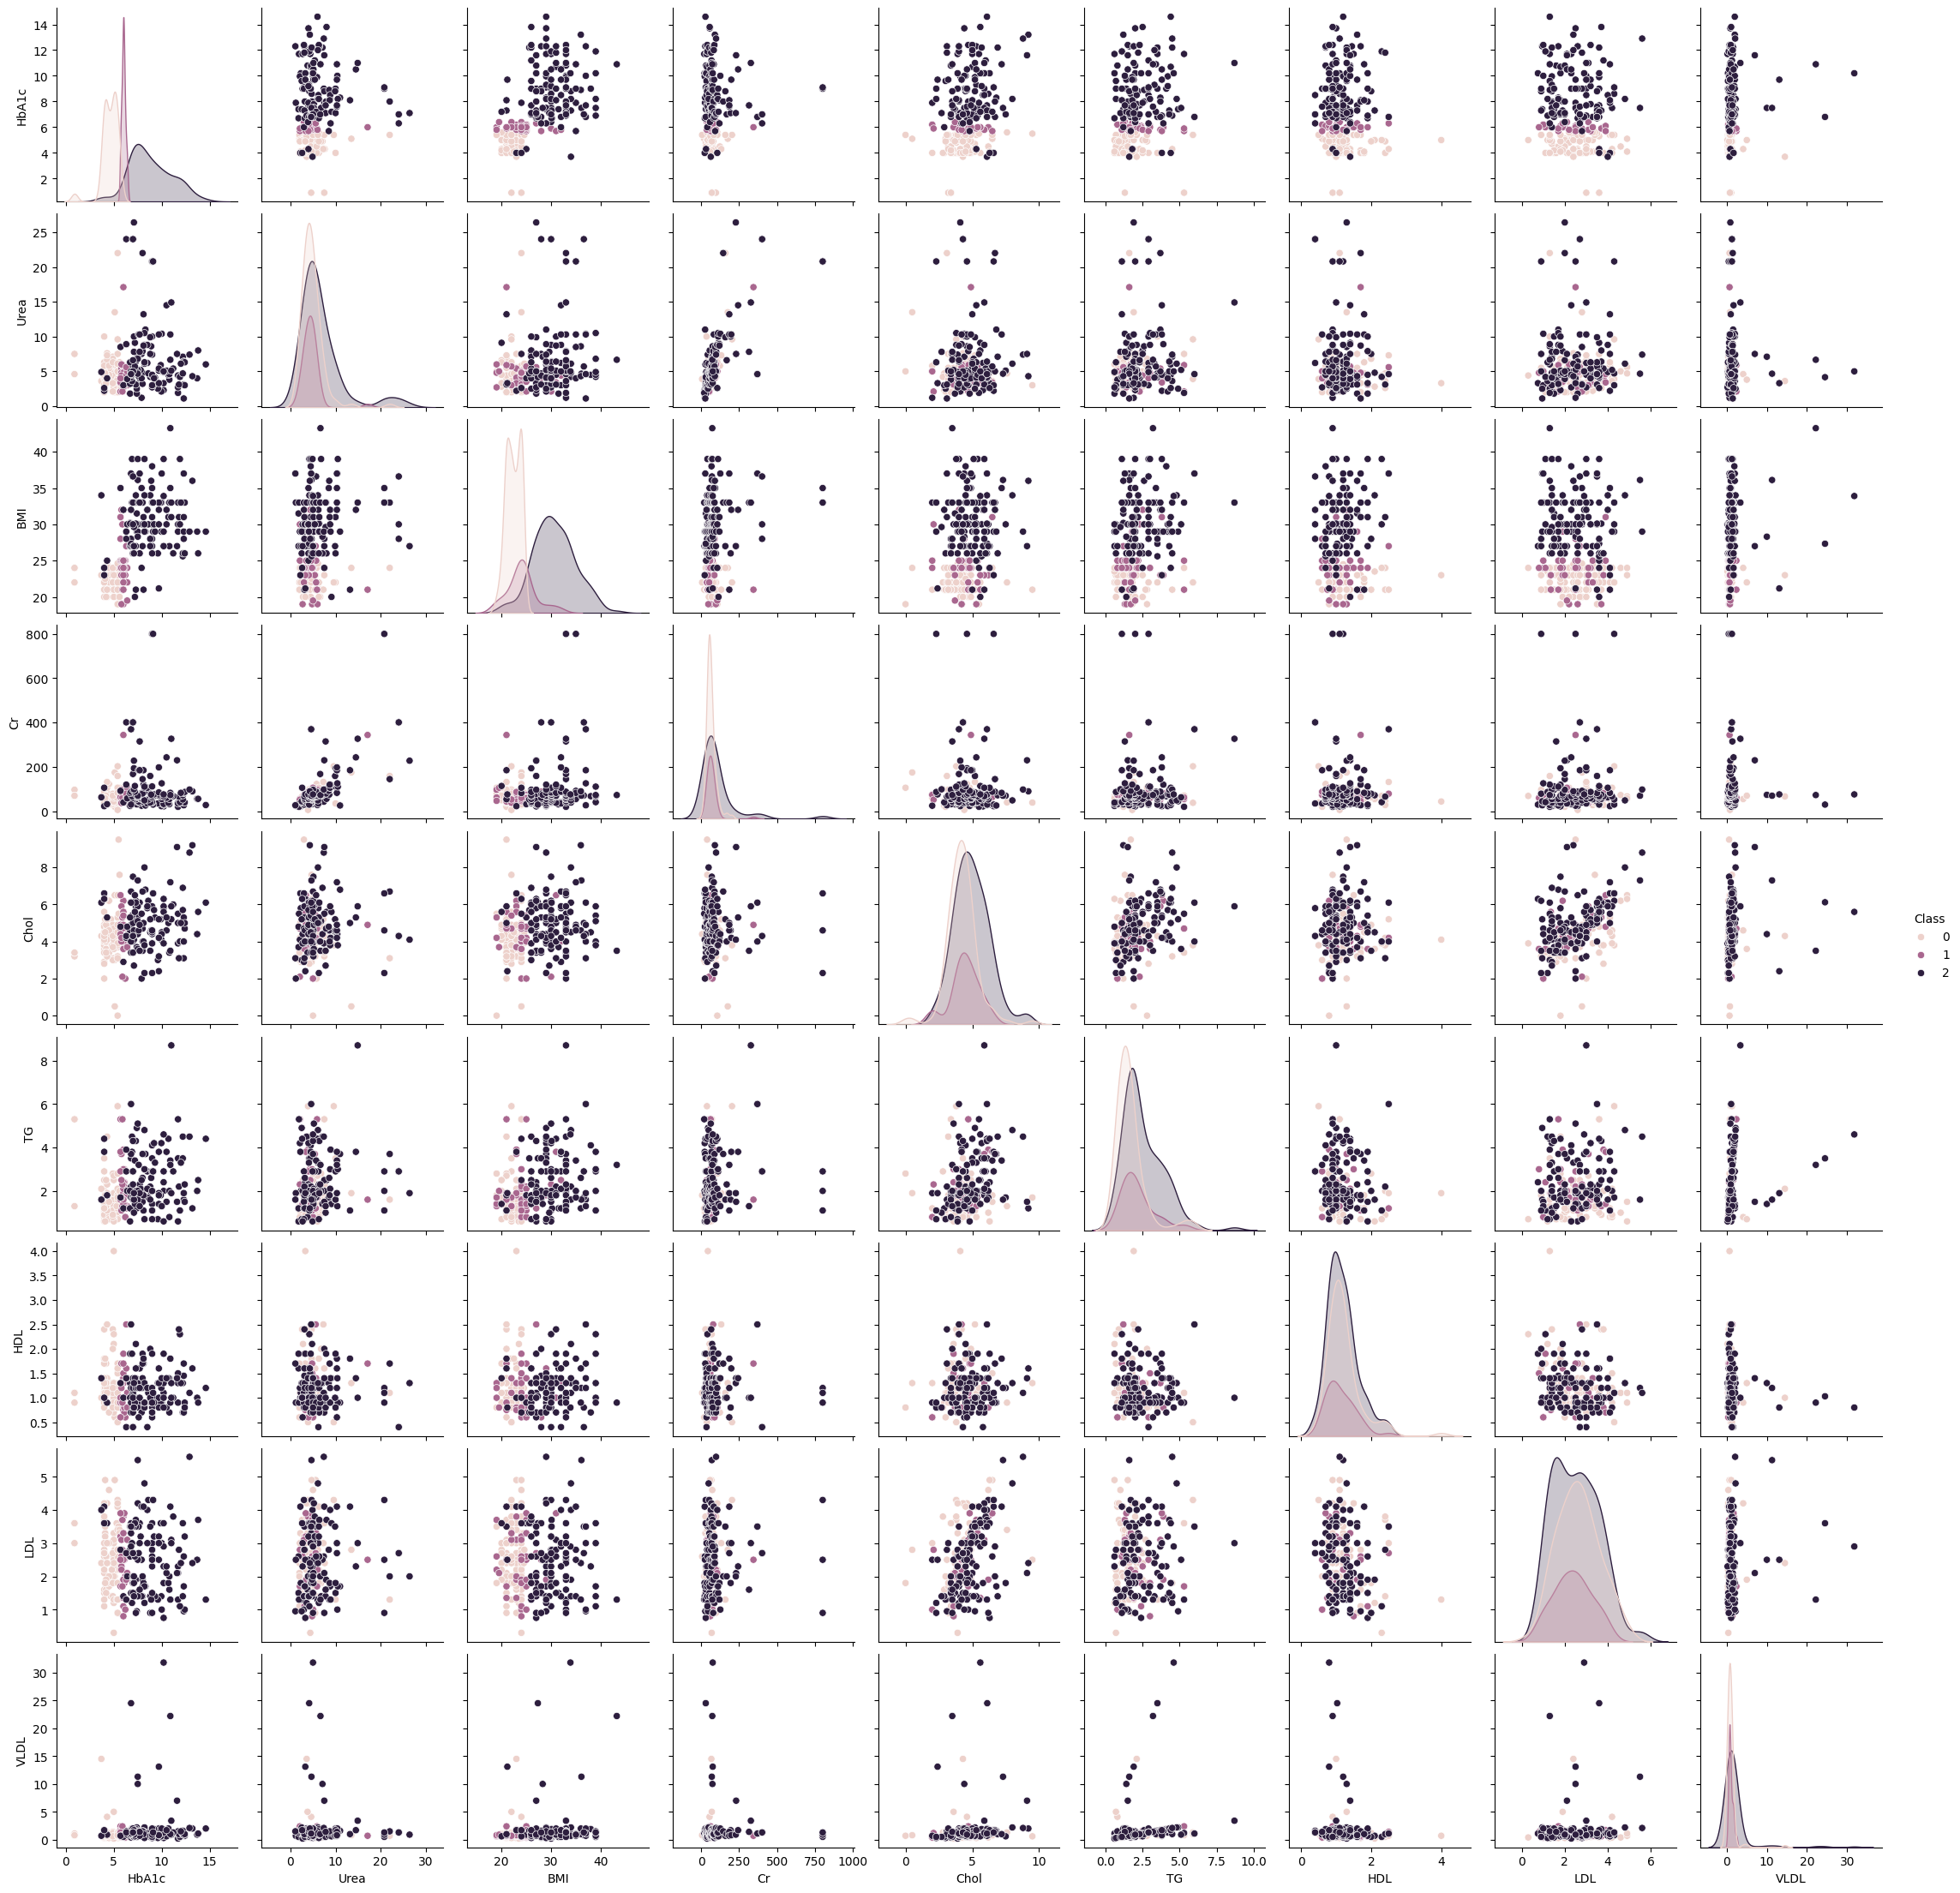

In [4]:
sns.pairplot(df[["HbA1c", "Urea", "BMI","Cr","Chol","TG","HDL","LDL","VLDL", "Class"]], hue="Class")
plt.show()

En la diagonal aparecen histogramas de dichas variables, mientras que en el resto aparecen diagramas de dispersión de las dos variables que intersecan. En este caso, la variable "Class", determina como se colorearán los puntos a partir de la clase a la que pertenezcan.
La variable HbA1c en este caso resulta muy importante para la clasificación, ya que se puede observar en los gráficos de dispersión dependientes de esta, que los pacientes están separados de manera relativamente clara por clases.
¿De qué sirve esto? Si yo tengo una variable claramente separada por clases, la información que esta pueda brindarme será mucho más rica que uno que no esté separada claramente, ya que la posición de la paciente de mis usuarios acarrea información  de manera más segura.

In [5]:
# X: todas las columnas menos "Class"
X = df.drop("Class", axis=1)

# y: la columna objetivo
y = df["Class"]

# dividir el dataset (80% entrenamiento, 20% testeo)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% para test
    random_state=42,    # semilla para reproducibilidad
    stratify=y          # mantiene la proporción de clases
)

print("Tamaño entrenamiento:", X_train.shape[0])
print("Tamaño testeo:", X_test.shape[0])


Tamaño entrenamiento: 211
Tamaño testeo: 53


##Discriminante en LDA
Se asume que cada clase $c$ sigue una distribución normal multivariada
            \begin{equation}
    p(x \mid y=c) \sim \mathcal{N}(\mu_c, \Sigma)
    \end{equation}
A su vez, se considera que todas las clases comparten la misma matriz de covarianza ("Σ"). También, se considera la probabilidad de la clase como
 $\pi_c = P(y = c)$.

  - Fórmula general del discriminante
  \begin{equation}
  \delta_c(x) = x^{T}\Sigma^{-1}\mu_c - \tfrac{1}{2}\mu_c^{T}\Sigma^{-1}\mu_c + \ln(\pi_c)
  \end{equation}
  Donde:
    - $x$ $\rightarrow$ vector de características de la muestra.
    - $\mu_c$ $\rightarrow$ media de la clase $c$.
    - $\Sigma$ $\rightarrow$ matriz de covarianza compartida.
    - $\pi_c$ $\rightarrow$ probabilidad a priori de la clase $c$.
    
    Esta resulta en una función lineal.La predicción soft del algoritmo será el softmax de la función discriminante, mientras que la predcción hard será el argmax de la misma.
    
    \begin{equation}
    \hat{P}(y|x) = soft\max_{c} \, \delta_c(x)
    \end{equation}
    \begin{equation}
    \hat{y} = \arg\max_{c} \, \delta_c(x)
    \end{equation}
    
   

##Discriminante en QDA
AL igual que en LDA, se asume que cada clase $c$ sigue una distribución normal multivariada:
    \begin{equation}
    p(x \mid y=c) \sim \mathcal{N}(\mu_c, \Sigma_c)
    \end{equation}
y también se considera la probabilidad de la clase como
 $\pi_c = P(y = c)$. Pero en este algoritmo, a diferencia del LDA, cada clase tiene su propia matriz de covarianza $Σ_c$

  - Fórmula general del discriminante
  La función discriminante de QDA para una clase $c$ es:
  \begin{equation}
  \delta_c(x) = -\tfrac{1}{2}(x - \mu_c)^{T}\Sigma_c^{-1}(x - \mu_c)
              - \tfrac{1}{2}\ln \lvert \Sigma_c \rvert
              + \ln(\pi_c)
  \end{equation}
  Donde:
    - $x$ $\rightarrow$ vector de características de la muestra.
    - $\mu_c$ $\rightarrow$ media de la clase $c$.
    - $\Sigma_c$ $\rightarrow$ matriz de covarianza de la clase $c$.
    - $|\Sigma_c|$ $\rightarrow$ determinante de la matriz de covarianza de la clase $c$.
    - $\pi_c$ $\rightarrow$ probabilidad a priori de la clase $c$.

    En este caso la función es cuadrática. Del mismo modo que LDA, la clase predicha será el argmax de la función.

In [6]:
class LDA_QDA:
    def __init__(self, LDA=True, reg_lambda=1e-6):
        """
        LDA=True  -> usa covarianza compartida (Linear Discriminant Analysis).
        LDA=False -> usa covarianzas por clase (Quadratic Discriminant Analysis).
        reg_lambda -> regularización para invertir matrices (añade λI).
        """
        self.LDA = LDA
        self.reg_lambda = reg_lambda
        self.classes_ = None
        self.priors_ = None            # π_k
        self.means_ = None             # μ_k: dict {clase: vector}
        self.cov_ = None               # Σ (si LDA)
        self.cov_per_class_ = None     # {clase: Σ_k} (si QDA)
        self.inv_cov_ = None
        self.inv_cov_per_class_ = None
        self.log_det_cov_per_class_ = None

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)
        n, d = X.shape

        self.classes_, counts = np.unique(y, return_counts=True)
        K = len(self.classes_)

        # Priors π_k (proporciones muestrales)
        self.priors_ = {c: counts[i] / n for i, c in enumerate(self.classes_)}

        # Medias μ_k
        self.means_ = {c: X[y == c].mean(axis=0) for c in self.classes_}

        if self.LDA:
            # Covarianza pooled: Σ = sum_k ((n_k-1) S_k) / (n - K), con S_k la covarianza muestral de la clase k
            pooled = np.zeros((d, d))
            for c in self.classes_:
                Xc = X[y == c]
                # Me aseguro que al menos haya dos muestras para calcular la varianza
                if Xc.shape[0] > 1:
                    Sk = np.cov(Xc, rowvar=False, ddof=1)
                    # Manejo el caso de Sk unidimensional
                    if Sk.ndim == 0:
                      Sk = Sk.reshape(1, 1)
                else:
                    # Si solo hay una muestra, la varianza es 0
                    Sk = np.zeros((d,d))
                pooled += (Xc.shape[0] - 1) * Sk
            pooled = pooled / (n - K)
            pooled += self.reg_lambda * np.eye(d)
            self.cov_ = pooled
            self.inv_cov_ = np.linalg.inv(self.cov_)
        else:
            # Covarianza por clase Σ_k
            self.cov_per_class_ = {}
            self.inv_cov_per_class_ = {}
            self.log_det_cov_per_class_ = {}
            for c in self.classes_:
                Xc = X[y == c]
                # Me aseguro que al menos haya dos muestras para calcular la varianza
                if Xc.shape[0] > 1:
                    Sk = np.cov(Xc, rowvar=False, ddof=1)
                    # Manejo el caso de Sk unidimensional
                    if Sk.ndim == 0:
                      Sk = Sk.reshape(1, 1)
                else:
                    #Caso de covarianza 0
                    Sk = np.zeros((d,d))

                Sk += self.reg_lambda * np.eye(d)
                self.cov_per_class_[c] = Sk
                inv = np.linalg.inv(Sk)
                sign, logdet = np.linalg.slogdet(Sk)
                self.inv_cov_per_class_[c] = inv
                self.log_det_cov_per_class_[c] = logdet

        return self

    def _discriminant_scores(self, X):
        """
        Devuelve matriz (n_muestras, n_clases) con los δ_k(x).
        """
        X = np.asarray(X, dtype=float)
        n, d = X.shape
        scores = np.zeros((n, len(self.classes_)))

        if self.LDA:
            # δ_k(x) = x^T Σ^{-1} μ_k - 0.5 μ_k^T Σ^{-1} μ_k + log π_k
            for j, c in enumerate(self.classes_):
                mu = self.means_[c]
                term1 = X @ (self.inv_cov_ @ mu)
                term2 = -0.5 * (mu @ (self.inv_cov_ @ mu))
                term3 = np.log(self.priors_[c])
                scores[:, j] = term1 + term2 + term3
        else:
            # δ_k(x) = -0.5 log|Σ_k| - 0.5 (x-μ_k)^T Σ_k^{-1} (x-μ_k) + log π_k
            for j, c in enumerate(self.classes_):
                mu = self.means_[c]
                inv = self.inv_cov_per_class_[c]
                logdet = self.log_det_cov_per_class_[c]
                xc = X - mu
                # manejo la unidimensionalidad
                if d == 1:
                    quad = (xc * inv * xc).flatten()
                else:
                    quad = np.einsum('ij,ji->i', xc @ inv, xc.T)  # término cuadrático por fila
                scores[:, j] = -0.5 * (logdet + quad) + np.log(self.priors_[c])

        return scores

    def predict_discriminant(self, X):
        """
        Devuelve DataFrame con δ_k(x) por clase (útil como 'soft' alternativo).
        """
        sc = self._discriminant_scores(X)
        cols = [f"delta_class_{c}" for c in self.classes_]
        return pd.DataFrame(sc, columns=cols)

    def predict_prob(self, X):
        """
        Probabilidades posteriores P(y=k|x) aplicando softmax a δ_k(x).
        """
        scores = self._discriminant_scores(X)
        scores = scores - scores.max(axis=1, keepdims=True)  # estabilidad numérica
        exp_scores = np.exp(scores)
        probs = exp_scores / exp_scores.sum(axis=1, keepdims=True)
        return pd.DataFrame(probs, columns=[f"p_class_{c}" for c in self.classes_])

    def predict(self, X):
        """
        Predicción hard: argmax de δ_k(x).
        """
        scores = self._discriminant_scores(X)
        idx = np.argmax(scores, axis=1)
        return np.array([self.classes_[i] for i in idx])

In [7]:
X = df[["HbA1c"]].values
y = df["Class"].values

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

lda = LDA_QDA(LDA=True, reg_lambda=1e-6).fit(X_tr, y_tr)
y_lda_pred = lda.predict(X_te)

qda = LDA_QDA(LDA=False, reg_lambda=1e-6).fit(X_tr, y_tr)
y_qda_pred = qda.predict(X_te)

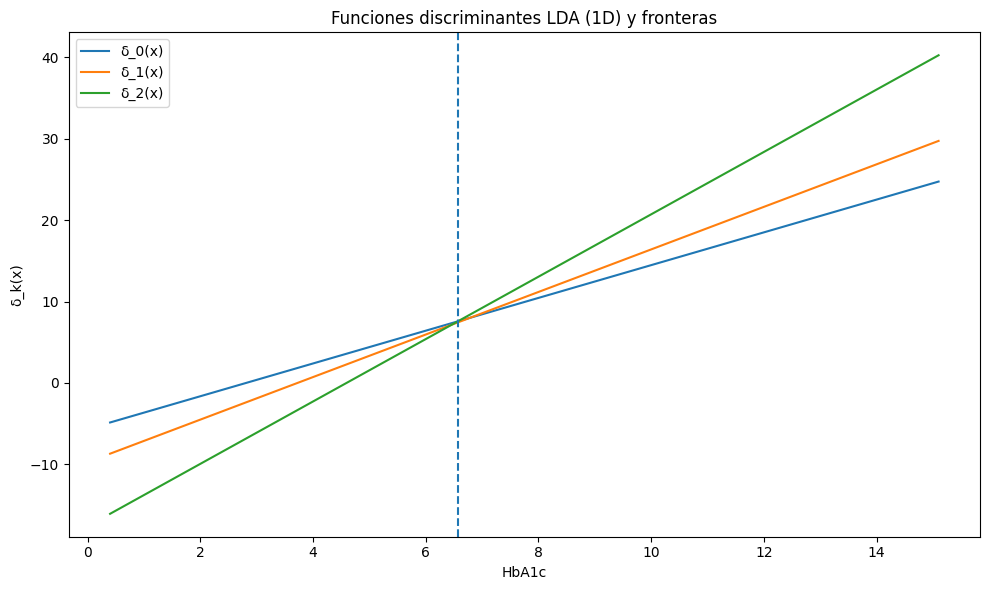

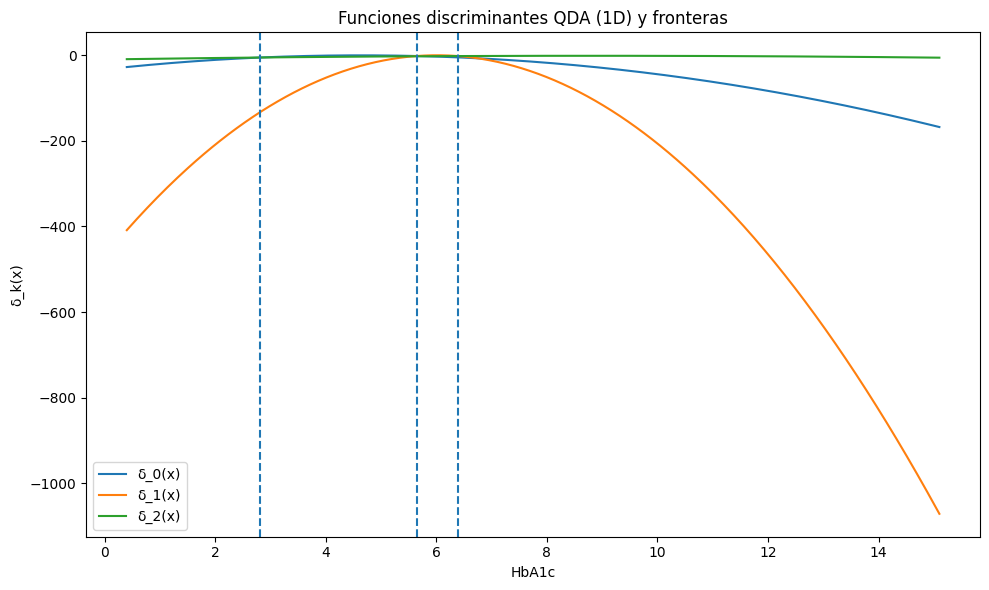

Fronteras LDA: [6.57105263]
Fronteras QDA: [2.81315789 5.65       6.38684211]


In [8]:
# Grid 1D para evaluar δ_k(x)
x_min, x_max = X.min() - 0.5, X.max() + 0.5
grid = np.linspace(x_min, x_max, 400).reshape(-1, 1)

scores_lda = lda.predict_discriminant(grid)
scores_qda = qda.predict_discriminant(grid)

# Helper: fronteras donde cambia el argmax de δ_k(x)
def decision_boundaries_from_scores(x_grid, scores):
    arg = np.argmax(scores, axis=1)
    changes = np.where(np.diff(arg) != 0)[0]
    bounds = [(x_grid[i] + x_grid[i+1]) / 2.0 for i in changes]
    return np.array(bounds).ravel()

bounds_lda = decision_boundaries_from_scores(grid.ravel(), scores_lda.values) # Convierto a numpy
bounds_qda = decision_boundaries_from_scores(grid.ravel(), scores_qda.values)

# ---------------------
# Plot LDA
# ---------------------
plt.figure(figsize=(10, 6))
for j, c in enumerate(lda.classes_):
    plt.plot(grid, scores_lda[f"delta_class_{c}"].values, label=f"δ_{c}(x)") # Accedo a las columnas y las hago numpy
for b in bounds_lda:
    plt.axvline(b, linestyle="--")
plt.xlabel("HbA1c")
plt.ylabel("δ_k(x)")
plt.title("Funciones discriminantes LDA (1D) y fronteras")
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------
# Plot QDA
# ---------------------
plt.figure(figsize=(10, 6))
for j, c in enumerate(qda.classes_):
    plt.plot(grid, scores_qda[f"delta_class_{c}"].values, label=f"δ_{c}(x)") # accedo y convierto a numpy array
for b in bounds_qda:
    plt.axvline(b, linestyle="--")
plt.xlabel("HbA1c")
plt.ylabel("δ_k(x)")
plt.title("Funciones discriminantes QDA (1D) y fronteras")
plt.legend()
plt.tight_layout()
plt.show()

print("Fronteras LDA:", bounds_lda)
print("Fronteras QDA:", bounds_qda)

Comparando ambos gráficos se puede observar las simplificaciones del modelo LDA en comparación con el QDA.
En el caso del LDA, podemos observar que las clases dominantes son la 0 y la 2, mientras que la clase 1 no queda contemplada como un argumento posible para el modelo. Es en esta distinción donde notamos las fallas del algortimo, cuando las proporciones de las clases resultan muy distantes entre sí, se corre el riesgo de dejarlas marginadas por el algoritmo.

Por otro lado, para el gráfico de QDA, las curvas permiten una configuración de regiones más compleja. Con esta nueva configuración, se aprecia un pico en el que el argumento máximo se corresponde con la clase 1, ausente en el LDA.

In [9]:
def evaluar(modelo, nombre):
    modelo.fit(X_tr, y_tr)
    y_pred = modelo.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    macro_f1 = f1_score(y_te, y_pred, average="macro")
    cm = confusion_matrix(y_te, y_pred, labels=modelo.classes_)
    print(f"\n=== {nombre} ===")
    print("Accuracy:", round(acc, 4))
    print("Macro-F1:", round(macro_f1, 4))
    print("Matriz de confusión (orden clases", list(modelo.classes_), "):\n", cm)

# LDA y QDA caseros
evaluar(LDA_QDA(LDA=True,  reg_lambda=1e-6),  "LDA")
evaluar(LDA_QDA(LDA=False, reg_lambda=1e-6),  "QDA")


=== LDA ===
Accuracy: 0.7925
Macro-F1: 0.5714
Matriz de confusión (orden clases [np.int64(0), np.int64(1), np.int64(2)] ):
 [[19  0  0]
 [ 8  0  0]
 [ 3  0 23]]

=== QDA ===
Accuracy: 0.9057
Macro-F1: 0.9119
Matriz de confusión (orden clases [np.int64(0), np.int64(1), np.int64(2)] ):
 [[16  0  3]
 [ 0  8  0]
 [ 1  1 24]]


Recordando:
## Macro F1

El **macro F1** se utiliza para medir el rendimiento de un clasificador en problemas de múltiples clases.

1. Para cada clase $k$, se calculan:

$$
Precision_k = \frac{TP_k}{TP_k + FP_k}
$$

$$
Recall_k = \frac{TP_k}{TP_k + FN_k}
$$

$$
F1_k = \frac{2 \cdot Precision_k \cdot Recall_k}{Precision_k + Recall_k}
$$

donde:

- $TP_k$: verdaderos positivos de la clase $k$  
- $FP_k$: falsos positivos de la clase $k$  
- $FN_k$: falsos negativos de la clase $k$

2. Luego, se promedian los $F1_k$ de todas las clases:

$$
F1_{\text{macro}} = \frac{1}{N} \sum_{k=1}^{N} F1_k
$$

donde $N$ es la cantidad total de clases.

El macro F1 trata a todas las clases con el mismo peso, aunque estén desbalanceadas.

---

## Accuracy

La **accuracy** (exactitud) mide la proporción de aciertos sobre el total de predicciones realizadas:

$$
Accuracy = \frac{\text{Número de predicciones correctas}}{\text{Número total de predicciones}}
$$

Más formalmente:

$$
Accuracy = \frac{\sum_{k=1}^N TP_k}{\sum_{k=1}^N (TP_k + FP_k + FN_k + TN_k)}
$$

donde:

- $TP_k$: verdaderos positivos de la clase $k$  
- $TN_k$: verdaderos negativos de la clase $k$  
- $FP_k$: falsos positivos de la clase $k$  
- $FN_k$: falsos negativos de la clase $k$

La accuracy funciona bien con clases balanceadas, pero puede ser engañosa si el dataset está muy desbalanceado.

Para el LDA, la accuracy resulta bastante diferente a la Macro-F1. Esto se debe principalmente a que el modelo LDA no es capaz de predecir la clase 1.

Como el Macro-F1 se calcula a partir del F1-score de cada clase, y luego se promedia con el mismo peso, la clase 1 al tener un F1 nulo, reduce considerablemente el valor del mismo.

Se realizan los ejercicios nuevamente pero esta vez considerando la característica del BMI

In [10]:
X = df[["HbA1c", "BMI"]].values
y = df["Class"].values

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

lda = LDA_QDA(LDA=True, reg_lambda=1e-6).fit(X_tr, y_tr)
y_lda_pred = lda.predict(X_te)

qda = LDA_QDA(LDA=False, reg_lambda=1e-6).fit(X_tr, y_tr)
y_qda_pred = qda.predict(X_te)

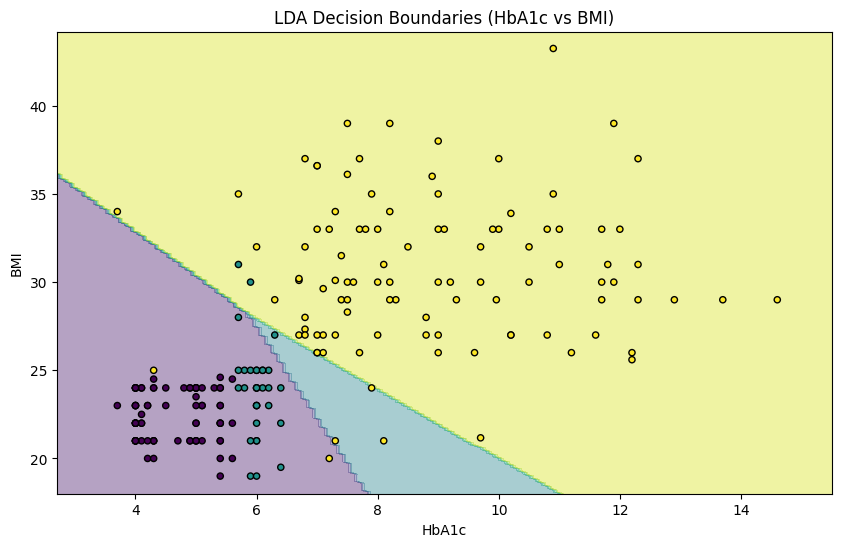

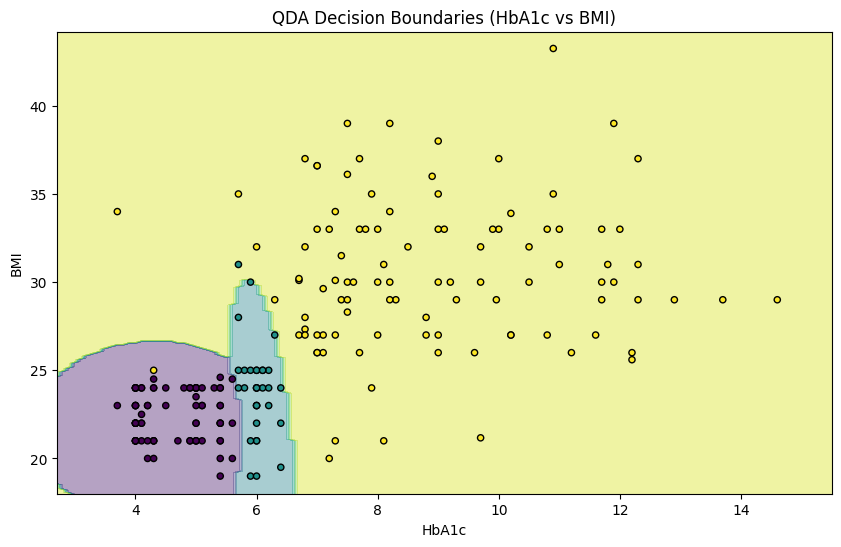

In [11]:
# Function to plot decision boundaries
def plot_decision_boundaries(X, y, model, title):
    # Saco los nínimos y máximos de X e Y para plotear después
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predigo la clase para cada punto de la meshgird
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    plt.xlabel('HbA1c')
    plt.ylabel('BMI')
    plt.title(title)
    plt.show()

plot_decision_boundaries(X_tr, y_tr, lda, "LDA Decision Boundaries (HbA1c vs BMI)")
plot_decision_boundaries(X_tr, y_tr, qda, "QDA Decision Boundaries (HbA1c vs BMI)")

Como se pudo observar en el caso en el que solo se utilizaba HbA1c, el LDA separa claramente las clases dominantes ,0 y 2, pero tiene ciertas dificultades con la clase 1. De todos modos, con el agregado del BMI como característica, se puede observar una región donde el modelo predice la clase 1, aunque con dificultades.

Por otro lado, con el modelo QDA, el modelo distingue tres regiones bien marcadas para todas las clases.

In [12]:
def evaluar(modelo, nombre):
    modelo.fit(X_tr, y_tr)
    y_pred = modelo.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    macro_f1 = f1_score(y_te, y_pred, average="macro")
    cm = confusion_matrix(y_te, y_pred, labels=modelo.classes_)
    print(f"\n=== {nombre} ===")
    print("Accuracy:", round(acc, 4))
    print("Macro-F1:", round(macro_f1, 4))
    print("Matriz de confusión (orden clases", list(modelo.classes_), "):\n", cm)

evaluar(LDA_QDA(LDA=True,  reg_lambda=1e-6),  "LDA")
evaluar(LDA_QDA(LDA=False, reg_lambda=1e-6),  "QDA")


=== LDA ===
Accuracy: 0.8302
Macro-F1: 0.5959
Matriz de confusión (orden clases [np.int64(0), np.int64(1), np.int64(2)] ):
 [[19  0  0]
 [ 6  0  2]
 [ 1  0 25]]

=== QDA ===
Accuracy: 0.8868
Macro-F1: 0.8796
Matriz de confusión (orden clases [np.int64(0), np.int64(1), np.int64(2)] ):
 [[16  0  3]
 [ 0  6  2]
 [ 1  0 25]]


Nuevamente, para el caso del LDA, vemos malos resultados para el Macro-F1, e incluso un descenso en el rendimiento de la accuracy, dando a entender que el agregado de BMI como característica en este caso resulta contraproducente.

Por otra parte, notamos que el modelo QDA sigue dando buenos resultados, pero con un pequeño declive en comparación con el caso anterior.

Ahora, el caso en el que considero todas las características

In [13]:
X = df[["HbA1c", "BMI", "Urea","Cr","Chol","TG","HDL","LDL","VLDL"]].values
y = df["Class"].values

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

lda = LDA_QDA(LDA=True, reg_lambda=1e-6).fit(X_tr, y_tr)
y_lda_pred = lda.predict(X_te)

qda = LDA_QDA(LDA=False, reg_lambda=1e-6).fit(X_tr, y_tr)
y_qda_pred = qda.predict(X_te)

In [14]:
def evaluar(modelo, nombre):
    modelo.fit(X_tr, y_tr)
    y_pred = modelo.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    macro_f1 = f1_score(y_te, y_pred, average="macro")
    cm = confusion_matrix(y_te, y_pred, labels=modelo.classes_)
    print(f"\n=== {nombre} ===")
    print("Accuracy:", round(acc, 4))
    print("Macro-F1:", round(macro_f1, 4))
    print("Matriz de confusión (orden clases", list(modelo.classes_), "):\n", cm)


evaluar(LDA_QDA(LDA=True,  reg_lambda=1e-6),  "LDA")
evaluar(LDA_QDA(LDA=False, reg_lambda=1e-6),  "QDA")


=== LDA ===
Accuracy: 0.8302
Macro-F1: 0.6602
Matriz de confusión (orden clases [np.int64(0), np.int64(1), np.int64(2)] ):
 [[18  1  0]
 [ 5  1  2]
 [ 1  0 25]]

=== QDA ===
Accuracy: 0.9434
Macro-F1: 0.9532
Matriz de confusión (orden clases [np.int64(0), np.int64(1), np.int64(2)] ):
 [[16  0  3]
 [ 0  8  0]
 [ 0  0 26]]


Utilizando todas las características se puede observar una mejora en el desempeño de los algortimos.
Para el caso de LDA, la accuracy se mantuvo constante, pero como gran mejora se puede observar que ahora es capaz de predecir la clase 1, a diferencia de los casos anteriores.

Para el caso de QDA, el algoritmo sigue teniendo un gran desempeño, con una considerable mejora en su accuracy, Macro-F1 y matriz de confusión.

##c) Vectores más cercanos

El algoritmo K-Nearest Neighbors (KNN) es un método de regresión y de aprendizaje para clasificación. Este consiste en clasificar cada punto nuevo a partir de sus K vecinos más cercanos en el conjunto de entrenamiento.
Primero, se calcula la distancia entre la muestra nueva y las anteriores del conjunto, luego se seleccionan los K vecinos más cercanos y finalmente se clasifica a partir de la clase más frecuente entre vecinos.

Para el valor de K, es importante reconocer que un valor de K muy pequeño, da como resultado un modelo sensible al ruido (overfitting), mientras que un K muy grande resulta en un modelo general y poco preciso (underfitting)

In [15]:
# Implemento la clase para ejecutar el algoritmo KNN
from collections import Counter

class KNN:
    def __init__(self, k, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric
        self.X_train = None
        self.y_train = None

    # Etapa de "entrenamiento" en la cual solo se guardan los datos
    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    # Funcion para calcular la distancia dependiendo que metrica se usa
    def _distance(self,x1,x2):
        if self.distance_metric == 'euclidean':
            distance = np.sqrt(np.sum((x1-x2)**2))
        if self.distance_metric == 'manhattan':
            distance = np.sum(np.abs(x1-x2))
        return distance

    # Etapa de testeo soft (devuelve probabilidades)
    def predict_proba(self, X):
        y_pred = []
        for x in X:
            # Calcular todas las distancias respecto a los datos de entrenamiento
            distances = [self._distance(x, x_train) for x_train in self.X_train]

            # Obtengo los índices de los k vecinos más cercanos
            idx = np.argsort(distances)[:self.k] # Devuelve los indices de forma tal que el array resulta en orden ascendente
            #Es decir, el primer indice resulta a la distancia más pequeña, el segundo a la segunda más pequeña, y así sucesivamente

            # Obtengo las clases de los k vecinos más cercanos
            k_nearest_neighbors = self.y_train[idx]

            # Cuento las ocurrencias de cada clase
            class_counts = Counter(k_nearest_neighbors)# Bien en criollo, la función counter me devuelve la cantidad de elementos que pertenecen a una clase

            # Calculo las probabilidades de cada clase
            prob = np.zeros(len(np.unique(self.y_train)))

            for c in class_counts:
                prob[c] = class_counts[c] / self.k

            y_pred.append(prob)

        return np.array(y_pred)

      # Etapa de testeo hard, devuelve la clase más probable
    def predict(self,X):
        y_pred = self.predict_proba(X)
        return np.argmax(y_pred, axis=1)

In [16]:
knn = KNN(k=9, distance_metric='euclidean')
knn.fit(X_train[['HbA1c']], y_train)

In [17]:
# Entreno
knn.fit(X_train[['HbA1c']], y_train)

# Predicción hard
y_pred_knn = knn.predict(X_test[['HbA1c']].values)
y_pred_knn_tr = knn.predict(X_train[['HbA1c']].values)

# Accuracy
acc_knn = accuracy_score(y_test, y_pred_knn)
acc_knn_tr = accuracy_score(y_train, y_pred_knn_tr)

# Matriz de confusión
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_knn_tr = confusion_matrix(y_train, y_pred_knn_tr)

# F1 macro
f1_knn = f1_score(y_test, y_pred_knn, average='macro')
f1_knn_tr = f1_score(y_train, y_pred_knn_tr, average='macro')

# ===KNN===
print("SET DE TESTEO")
print("Accuracy:", acc_knn)
print("Macro-F1:", f1_knn)
print("Matriz de confusión:\n", cm_knn)

print("\nSET DE ENTRENAMIENTO")
print("Accuracy:", acc_knn_tr)
print("Macro-F1:", f1_knn_tr)
print("Matriz de confusión:\n", cm_knn_tr)

SET DE TESTEO
Accuracy: 0.9433962264150944
Macro-F1: 0.9340077911506484
Matriz de confusión:
 [[19  0  0]
 [ 0  8  0]
 [ 1  2 23]]

SET DE ENTRENAMIENTO
Accuracy: 0.9715639810426541
Macro-F1: 0.9686041900130692
Matriz de confusión:
 [[77  0  0]
 [ 0 32  0]
 [ 3  3 96]]


El algoritmo, con una única característica, resulta muy exitoso, superando a las implementcaiones de LDA y QDA en todos los casos anteriores.

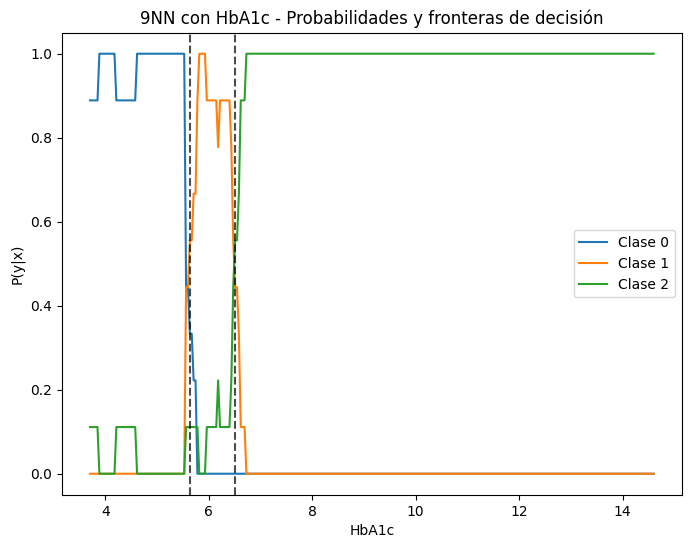

In [18]:
# Rango de HbA1c
x_vals = np.linspace(X_train['HbA1c'].min(), X_train['HbA1c'].max(), 300).reshape(-1, 1)

# Probabilidades predichas
probs_knn = knn.predict_proba(x_vals)

# Predicciones duras (para fronteras)
preds_knn = knn.predict(x_vals)

plt.figure(figsize=(8,6))

# Graficar curvas de probabilidad
for c in np.unique(y_train):
    plt.plot(x_vals, probs_knn[:, c], label=f"Clase {c}")

# Detectar fronteras de decisión: donde cambia la clase predicha
for i in range(1, len(preds_knn)):
    if preds_knn[i] != preds_knn[i-1]:
        frontera = x_vals[i][0]
        plt.axvline(x=frontera, color="k", linestyle="--", alpha=0.7)

plt.xlabel("HbA1c")
plt.ylabel("P(y|x)")
plt.title("9NN con HbA1c - Probabilidades y fronteras de decisión")
plt.legend()
plt.show()

In [19]:
X_test=X_test.values
X_train=X_train.values

SET DE TESTEO
Accuracy: 0.9245283018867925
Macro-F1: 0.9094163981382026
Matriz de confusión:
 [[18  1  0]
 [ 0  8  0]
 [ 1  2 23]]

SET DE ENTRENAMIENTO
Accuracy: 0.966824644549763
Macro-F1: 0.9648023251863348
Matriz de confusión:
 [[76  0  1]
 [ 0 32  0]
 [ 3  3 96]]


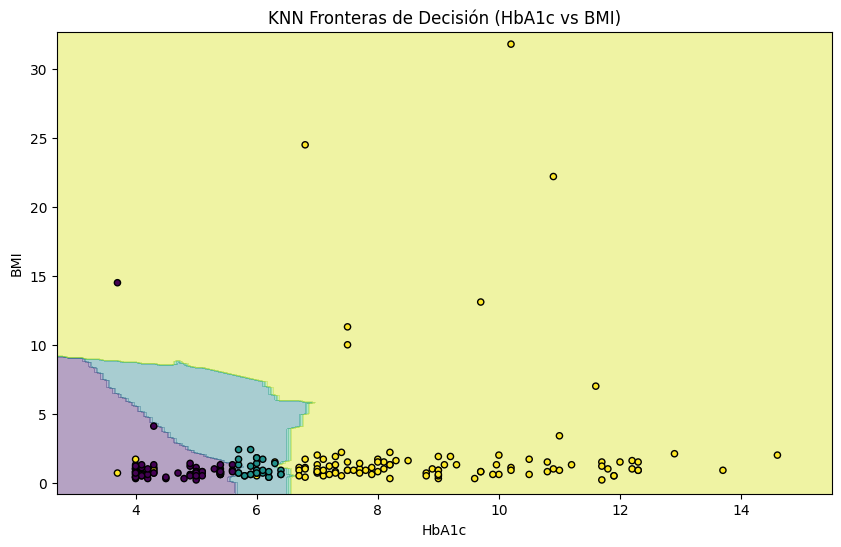

In [20]:
# Incorporo el BMI

# Entreno
knn.fit(X_train[:, [4, 9]], y_train) # Use integer indexing for HbA1c (index 4) and BMI (index 9)

# Predicción hard
y_pred_knn_BMI = knn.predict(X_test[:, [4, 9]]) # Use integer indexing for HbA1c (index 4) and BMI (index 9)
y_pred_knn_BMI_tr = knn.predict(X_train[:, [4, 9]]) # Use integer indexing for HbA1c (index 4) and BMI (index 9)

# Accuracy
acc_knn_BMI = accuracy_score(y_test, y_pred_knn_BMI)
acc_knn_BMI_tr = accuracy_score(y_train, y_pred_knn_BMI_tr)

# Matriz de confusión
cm_knn_BMI = confusion_matrix(y_test, y_pred_knn_BMI)
cm_knn_BMI_tr = confusion_matrix(y_train, y_pred_knn_BMI_tr)

# F1 macro
f1_knn_BMI = f1_score(y_test, y_pred_knn_BMI, average='macro')
f1_knn_BMI_tr = f1_score(y_train, y_pred_knn_BMI_tr, average='macro')

# ===KNN===
print("SET DE TESTEO")
print("Accuracy:", acc_knn_BMI)
print("Macro-F1:", f1_knn_BMI)
print("Matriz de confusión:\n", cm_knn_BMI)

print("\nSET DE ENTRENAMIENTO")
print("Accuracy:", acc_knn_BMI_tr)
print("Macro-F1:", f1_knn_BMI_tr)
print("Matriz de confusión:\n", cm_knn_BMI_tr)

# Function to plot decision boundaries
def plot_decision_boundaries(X, y, model, title):


    # Saco los límites de X e Y
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predice la clase para cada punto del meshgrid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    plt.xlabel('HbA1c')
    plt.ylabel('BMI')
    plt.title(title)
    plt.show()

plot_decision_boundaries(X_train[:, [4, 9]], y_train, knn, "KNN Fronteras de Decisión (HbA1c vs BMI)")

Se puede observar que con el agregado del BMI como característica, hay un ligero declive en el rendimiento del algoritmo. Sin embargo, sigue dando muy buenos resultados, y en el gráfico se pueden observar regiones bien marcadas para todas las clases.

In [21]:
# Hago lo mismo pero con todas las categorias


# Entreno

knn.fit(X_train, y_train)

y_pred_knn_tot = knn.predict(X_test)
y_pred_knn_tot_tr = knn.predict(X_train)

# Accuracy
acc_knn_tot = accuracy_score(y_test,y_pred_knn_tot)
acc_knn_tot_tr = accuracy_score(y_train, y_pred_knn_tot_tr)

# Matriz
cm_knn_tot = confusion_matrix(y_test, y_pred_knn_tot)
cm_knn_tot_tr = confusion_matrix(y_train, y_pred_knn_tot_tr)

# F1 macro
f1_knn_tot = f1_score(y_test, y_pred_knn_tot, average='macro')
f1_knn_tot_tr = f1_score(y_train, y_pred_knn_tot_tr, average='macro')

#===KNN===
print("SET DE TESTEO")
print("Accuracy:", acc_knn_tot)
print("Macro-F1:", f1_knn_tot)
print("Matriz de confusión:\n", cm_knn_tot)

print("\nSET DE ENTRENAMIENTO")
print("Accuracy:", acc_knn_tot_tr)
print("Macro-F1:", f1_knn_tot_tr)
print("Matriz de confusión:\n", cm_knn_tot_tr)

SET DE TESTEO
Accuracy: 0.7358490566037735
Macro-F1: 0.6291486291486291
Matriz de confusión:
 [[13  0  6]
 [ 6  2  0]
 [ 1  1 24]]

SET DE ENTRENAMIENTO
Accuracy: 0.7867298578199052
Macro-F1: 0.6636540847067162
Matriz de confusión:
 [[64  3 10]
 [23  7  2]
 [ 7  0 95]]


Para este último caso, notamos que el uso de todas las categorías causa un gran declive en los resultados del algoritmo.